# SIREN MLP for Poisson-Boltzmann Equation

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import os
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from sklearn.metrics import roc_curve, auc
from mpl_toolkits.mplot3d import Axes3D

# Select computation device (GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate coordinate grid in [-1, 1] range
def get_mgrid(sidelen: int, dim: int = 2) -> torch.Tensor:
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors, indexing="ij"), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid


In [2]:
# SIREN layer with periodic sine activation
class SineLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first

        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)

        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features,
                                             1 / self.in_features)
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0,
                                             np.sqrt(6 / self.in_features) / self.omega_0)

    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))

    def forward_with_intermediate(self, input):
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate


class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False,
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()

        self.net = []
        self.net.append(SineLayer(in_features, hidden_features,
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features,
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)

            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0,
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)

            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features,
                                      is_first=False, omega_0=hidden_omega_0))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [3]:
# Differential operators using autograd
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

## Poisson-Boltzmann Equation


### Ground Truth Data


In [4]:
# Solve Poisson-Boltzmann equation numerically using finite differences
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

def solve_poisson_boltzmann_numerically(
    nx: int = 256,
    ny: int = 256,
    kappa: float = 1.0,
    source_strength: float = 5.0,
    source_center: tuple[float, float] = (0.0, 0.0),
    source_width: float = 0.1,
    max_iter: int = 100,
    tol: float = 1e-6,
):
    """
    Solve 2D Poisson-Boltzmann equation using finite differences and Newton-Raphson.
    """
    # Grid setup
    x = np.linspace(-1, 1, nx)
    y = np.linspace(-1, 1, ny)
    dx = x[1] - x[0]
    dy = y[1] - y[0]

    # Gaussian source term
    X, Y = np.meshgrid(x, y, indexing="ij")
    source = source_strength * np.exp(
        -((X - source_center[0]) ** 2 + (Y - source_center[1]) ** 2)
        / (2 * source_width**2)
    )
    source_flat = source.flatten()

    # Initial guess and Dirichlet boundaries (φ = 0 on boundary)
    phi = 0.1 * source.copy()
    phi[0, :] = 0.0
    phi[-1, :] = 0.0
    phi[:, 0] = 0.0
    phi[:, -1] = 0.0

    # 5-point Laplacian stencil
    N = nx * ny
    diag_main = np.full(N, -2 / dx**2 - 2 / dy**2)
    diag_x = np.full(N - 1, 1 / dx**2)
    diag_y = np.full(N - nx, 1 / dy**2)

    # Enforce boundary structure in Laplacian
    for i in range(nx):
        for j in range(ny):
            idx = i * ny + j
            if i == 0 or i == nx - 1 or j == 0 or j == ny - 1:
                diag_main[idx] = 1.0
                if idx < N - 1:
                    diag_x[idx] = 0.0
                if idx < N - nx:
                    diag_y[idx] = 0.0

    L = diags([diag_y, diag_x, diag_main, diag_x, diag_y],
              [-nx, -1, 0, 1, nx], format="csr")

    # Newton-Raphson iterations
    for _ in range(max_iter):
        phi_flat = phi.flatten()
        laplacian = L @ phi_flat
        residual = laplacian - kappa**2 * np.sinh(phi_flat) - source_flat

        for i in range(nx):
            for j in range(ny):
                if i == 0 or i == nx - 1 or j == 0 or j == ny - 1:
                    idx = i * ny + j
                    residual[idx] = 0.0

        max_residual = np.max(np.abs(residual))
        if max_residual < tol:
            break

        # Jacobian: L - κ² cosh(φ) I, with boundary rows fixed
        diag_jacobian = diag_main.copy() - kappa**2 * np.cosh(phi_flat)
        for i in range(nx):
            for j in range(ny):
                if i == 0 or i == nx - 1 or j == 0 or j == ny - 1:
                    idx = i * ny + j
                    diag_jacobian[idx] = 1.0

        J = diags([diag_y, diag_x, diag_jacobian, diag_x, diag_y],
                  [-nx, -1, 0, 1, nx], format="csr")

        delta_phi_flat = spsolve(J, -residual)
        phi = (phi_flat + 0.5 * delta_phi_flat).reshape(nx, ny)

        # Re-enforce Dirichlet boundary conditions
        phi[0, :] = 0.0
        phi[-1, :] = 0.0
        phi[:, 0] = 0.0
        phi[:, -1] = 0.0

    return phi, x, y, source

# Generate ground truth solution
phi_gt, x_gt, y_gt, source_gt = solve_poisson_boltzmann_numerically(
    nx=256, ny=256, kappa=1.0, source_strength=5.0, source_center=(0.0, 0.0), source_width=0.1
)

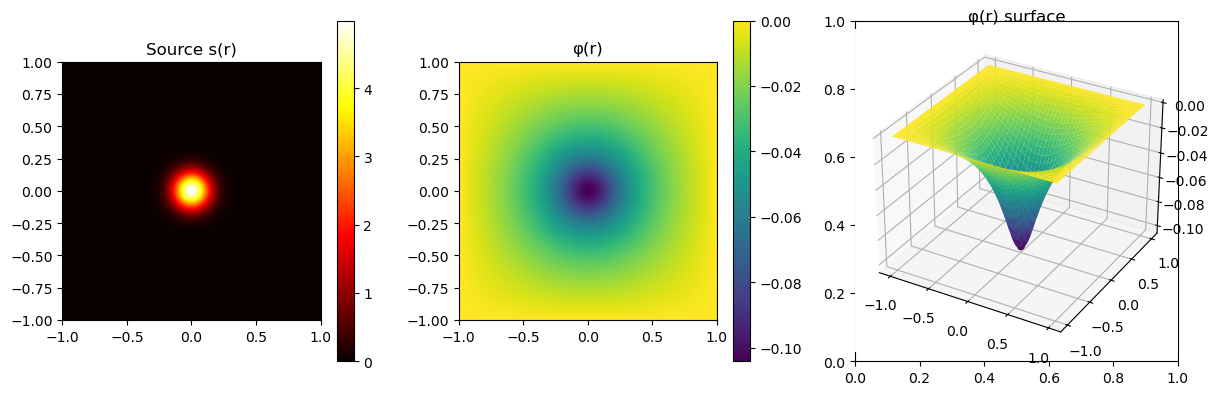

In [5]:
# Visualize ground truth source term and solution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Source term
im0 = axes[0].imshow(source_gt, cmap="hot", extent=[-1, 1, -1, 1], origin="lower")
axes[0].set_title("Source s(r)")
plt.colorbar(im0, ax=axes[0])

# 2D solution
im1 = axes[1].imshow(phi_gt, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
axes[1].set_title("φ(r)")
plt.colorbar(im1, ax=axes[1])

# 3D surface plot
X, Y = np.meshgrid(x_gt, y_gt)
ax2 = fig.add_subplot(133, projection="3d")
ax2.plot_surface(X, Y, phi_gt.T, cmap="viridis", linewidth=0, antialiased=True)
ax2.set_title("φ(r) surface")
plt.tight_layout()
plt.show()

In [6]:
# Dataset for coordinates and ground truth potential
class PoissonBoltzmannEqn(Dataset):
    def __init__(self, sidelength: int, gt_phi: torch.Tensor):
        self.coords = get_mgrid(sidelength, 2)
        self.gt_phi = gt_phi

    def __len__(self) -> int:
        return self.coords.shape[0]

    def __getitem__(self, idx: int):
        coords = self.coords[idx]
        gt_val = self.gt_phi[idx]
        return coords, gt_val

In [7]:
# Gaussian source term s(r) used in the PDE
def gaussian_source(coords: torch.Tensor, strength: float = 5.0, width: float = 0.1, center: tuple[float, float] = (0.0, 0.0)) -> torch.Tensor:
    x0, y0 = center
    x = coords[:, 0:1]
    y = coords[:, 1:2]
    return strength * torch.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * width**2))

In [8]:
# Dataset with ground truth
phi_gt_flat = torch.from_numpy(phi_gt.flatten()).float()
pb_obj = PoissonBoltzmannEqn(256, gt_phi=phi_gt_flat)

# SIREN model for scalar potential φ
pb_siren = Siren(in_features=2, out_features=1, hidden_features=256, hidden_layers=4,
                 outermost_linear=True, first_omega_0=30, hidden_omega_0=30).to(device)

# Initialize final layer for small, slightly negative outputs
with torch.no_grad():
    final_layer = pb_siren.net[-1]
    if isinstance(final_layer, nn.Linear):
        nn.init.normal_(final_layer.weight, mean=0.0, std=0.01)
        if final_layer.bias is not None:
            nn.init.constant_(final_layer.bias, -0.05)

In [ ]:
# PDE + boundary loss
def poisson_boltzmann_mse(model_pred: torch.Tensor, coords: torch.Tensor, kappa: float, boundary_weight: float = 10.0):
    # Fixed Gaussian source
    source_term = gaussian_source(coords, strength=5.0, width=0.1, center=(0.0, 0.0))
    model_pred_safe = torch.tanh(model_pred)
    laplace_pred = laplace(model_pred_safe, coords)
    rhs = kappa**2 * torch.sinh(model_pred_safe) + source_term
    residual = laplace_pred - rhs
    pde_loss = (residual**2).mean()

    # Boundary loss: φ ≈ 0 on boundary
    x_coords = coords[:, 0]
    y_coords = coords[:, 1]
    tol = 0.01
    on_boundary = (
        (torch.abs(x_coords - 1.0) < tol)
        | (torch.abs(x_coords + 1.0) < tol)
        | (torch.abs(y_coords - 1.0) < tol)
        | (torch.abs(y_coords + 1.0) < tol)
    )
    boundary_pred = model_pred_safe[on_boundary]
    boundary_loss = (boundary_pred**2).mean()
    return pde_loss + boundary_weight * boundary_loss, pde_loss, boundary_loss

Step 0, Loss: 1194.631927


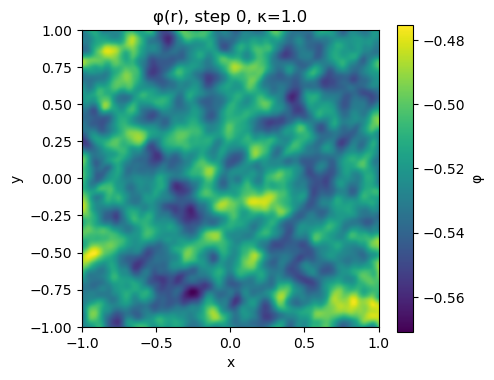

Step 99, Loss: 0.009919


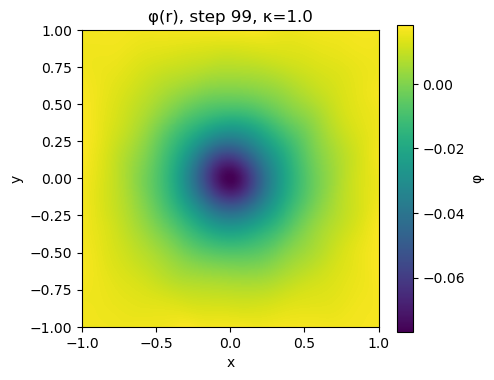

Step 199, Loss: 0.075328


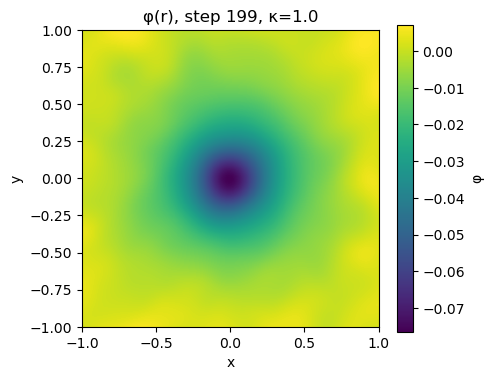

Step 299, Loss: 0.000902


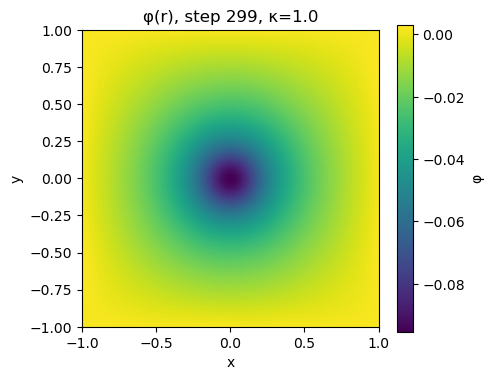

Step 399, Loss: 0.000630


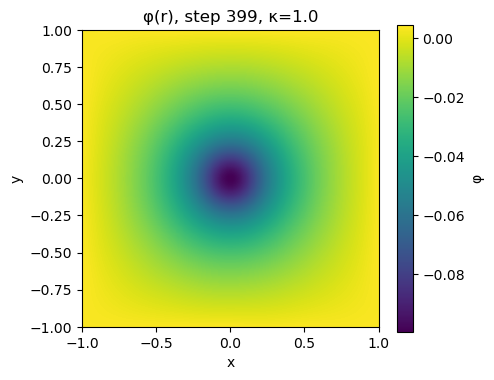

Step 499, Loss: 0.000819


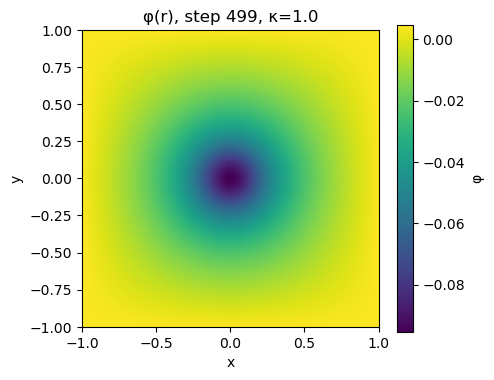

Step 599, Loss: 0.000001


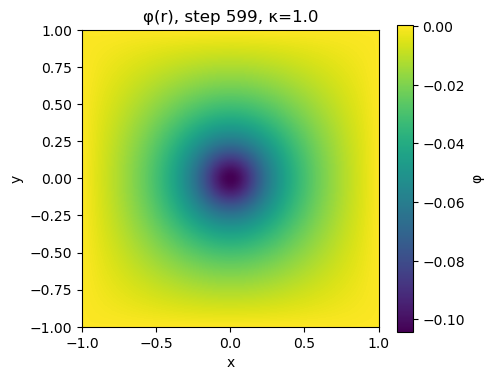

Step 699, Loss: 0.000000


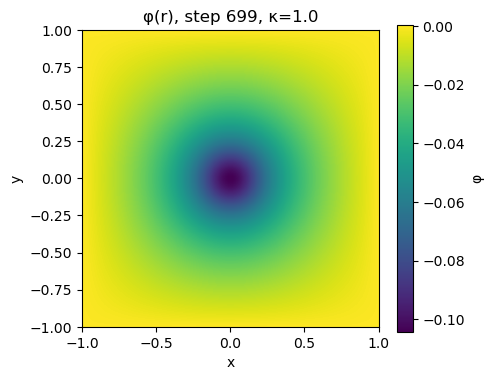

Step 799, Loss: 0.000000


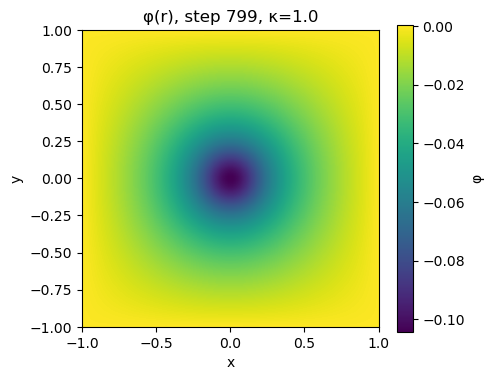

Step 899, Loss: 0.000000


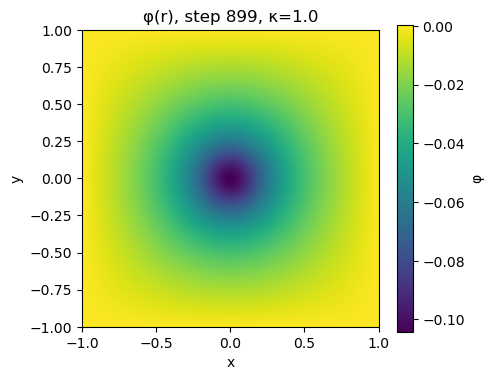

Step 999, Loss: 0.000000


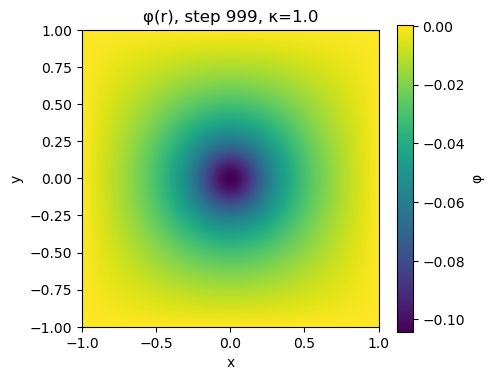

In [ ]:
# Training setup
save_dir_pb = "./checkpoints_pb"
os.makedirs(save_dir_pb, exist_ok=True)

dataloader_pb = DataLoader(pb_obj, batch_size=16384, shuffle=True)

# Hyperparameters
total_steps_pb = 1000
kappa = 1.0
initial_lr_pb = 1e-4

optim_pb = torch.optim.Adam(pb_siren.parameters(), lr=initial_lr_pb, betas=(0.9, 0.999), weight_decay=1e-6)

# Cosine learning rate decay
def get_lr_pb(step: int) -> float:
    t = step / max(total_steps_pb - 1, 1)
    return 0.5 * initial_lr_pb * (1.0 + np.cos(np.pi * t))

best_loss_pb = float("inf")
best_step = 0
best_checkpoint_path = os.path.join(save_dir_pb, "best_model.pth")

loss_history_pb = []
pde_loss_history = []
boundary_loss_history = []
grad_norm_history = []
time_history_pb = []

for step in range(total_steps_pb):
    start_time = time.time()

    # Update learning rate
    current_lr = get_lr_pb(step)
    for param_group in optim_pb.param_groups:
        param_group["lr"] = current_lr

    pb_siren.train()
    total_loss = 0.0
    total_pde_loss = 0.0
    total_boundary_loss = 0.0
    total_grad_norm = 0.0
    total_samples = 0
    num_batches = 0

    for coords, gt_vals in dataloader_pb:
        coords = coords.to(device)
        pred, coords_grad = pb_siren(coords)
        loss, pde_loss, boundary_loss = poisson_boltzmann_mse(pred, coords_grad, kappa, 10.0)

        optim_pb.zero_grad(set_to_none=True)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(pb_siren.parameters(), max_norm=1.0)
        optim_pb.step()

        batch_size = coords.shape[0]
        total_loss += loss.item() * batch_size
        total_pde_loss += pde_loss.item() * batch_size
        total_boundary_loss += boundary_loss.item() * batch_size
        total_grad_norm += grad_norm
        total_samples += batch_size
        num_batches += 1

    if total_samples == 0:
        continue

    avg_loss = total_loss / total_samples
    avg_pde_loss = total_pde_loss / total_samples
    avg_boundary_loss = total_boundary_loss / total_samples
    avg_grad_norm = total_grad_norm / num_batches if num_batches > 0 else 0.0

    loss_history_pb.append(avg_loss)
    pde_loss_history.append(avg_pde_loss)
    boundary_loss_history.append(avg_boundary_loss)
    grad_norm_history.append(avg_grad_norm)
    
    iter_time = time.time() - start_time
    time_history_pb.append(iter_time)
    
    # Save best model
    if avg_loss < best_loss_pb:
        best_loss_pb = avg_loss
        best_step = step
        torch.save(
            {
                "step": step,
                "model_state_dict": pb_siren.state_dict(),
                "optimizer_state_dict": optim_pb.state_dict(),
                "loss": avg_loss,
                "pde_loss": avg_pde_loss,
                "boundary_loss": avg_boundary_loss,
                "kappa": kappa,
            },
            best_checkpoint_path,
        )

    # Log and visualize periodically
    if step == 0 or (step + 1) % 100 == 0:
        print(f"Step {step}, Loss: {avg_loss:.6f}")

        pb_siren.eval()
        with torch.no_grad():
            # Generate predictions for visualization
            full_coords = pb_obj.coords
            batch_size_vis = 16384
            preds = []
            for i in range(0, len(full_coords), batch_size_vis):
                batch = full_coords[i : i + batch_size_vis].to(device)
                pred_batch, _ = pb_siren(batch)
                preds.append(pred_batch.cpu())
            full_pred = torch.cat(preds, dim=0)
            pred_phi = torch.tanh(full_pred)[:, 0].numpy().reshape(256, 256)

        plt.figure(figsize=(5, 4))
        plt.imshow(pred_phi, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
        plt.title(f"φ(r), step {step}, κ={kappa}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.colorbar(label="φ")
        plt.tight_layout()
        plt.show()

        print(iter_time)

PDE residuals: mean=1.610e-04, std=2.190e-04, max=1.830e-03


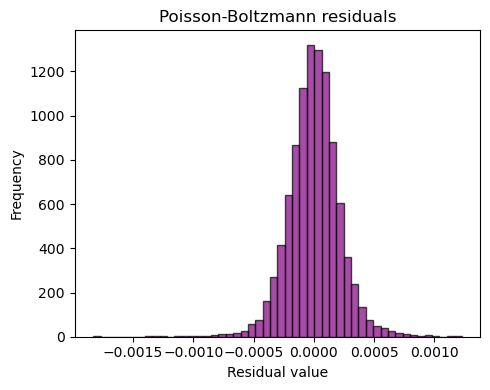

In [11]:
# Evaluate PDE residuals for a random subset of points
pb_siren.eval()
sample_size = 10_000
sample_indices = np.random.choice(len(pb_obj.coords), sample_size, replace=False)
sample_coords = pb_obj.coords[sample_indices].to(device)

pred, coords_grad = pb_siren(sample_coords)
pred_safe = torch.tanh(pred)
laplace_pred = laplace(pred_safe, coords_grad)
source_vals = gaussian_source(sample_coords, strength=5.0, width=0.1, center=(0.0, 0.0))
rhs = kappa**2 * torch.sinh(pred_safe) + source_vals
residual = laplace_pred - rhs
residual_np = residual.detach().cpu().numpy().flatten()

print(f"PDE residuals: mean={np.mean(np.abs(residual_np)):.3e}, std={np.std(residual_np):.3e}, max={np.max(np.abs(residual_np)):.3e}")

plt.figure(figsize=(5, 4))
plt.hist(residual_np, bins=50, color="purple", alpha=0.7, edgecolor="black")
plt.xlabel("Residual value")
plt.ylabel("Frequency")
plt.title("Poisson-Boltzmann residuals")
plt.tight_layout()
plt.show()

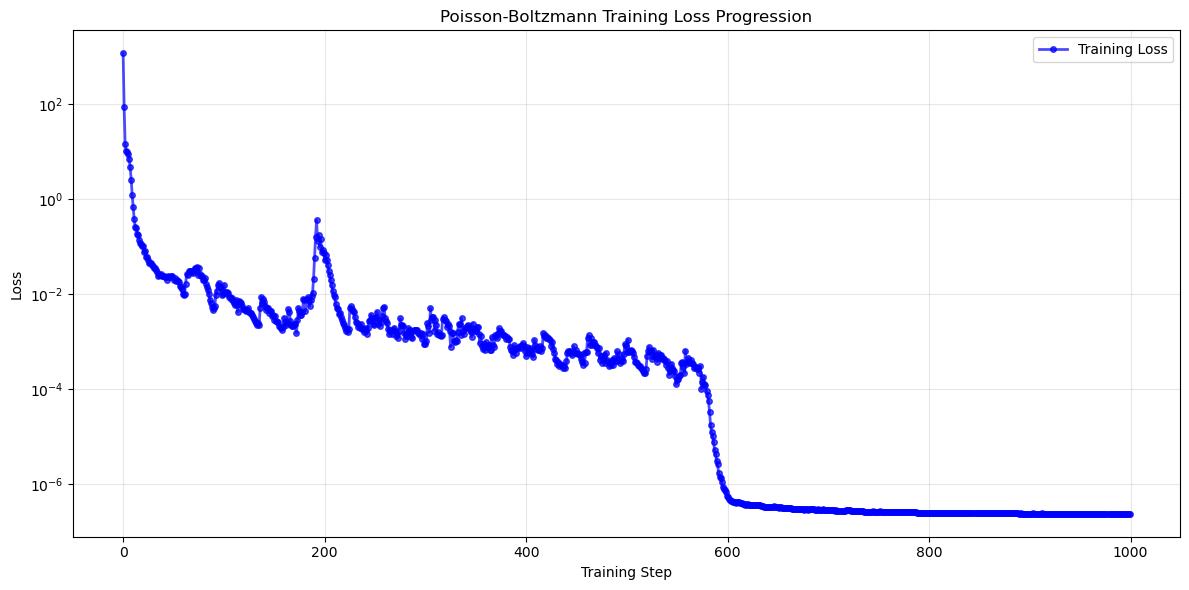

Initial Loss: 1.194632e+03, Final Loss: 2.366269e-07


In [12]:
if len(loss_history_pb) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(loss_history_pb, 'b-o', linewidth=2, markersize=4, label='Training Loss', alpha=0.7)
    plt.xlabel('Training Step')
    plt.ylabel('Loss')
    plt.title('Poisson-Boltzmann Training Loss Progression')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    print(f"Initial Loss: {loss_history_pb[0]:.6e}, Final Loss: {loss_history_pb[-1]:.6e}")


In [14]:
# Load the best model checkpoint
best_checkpoint_path = os.path.join(save_dir_pb, "best_model.pth")
if os.path.exists(best_checkpoint_path):
    checkpoint = torch.load(best_checkpoint_path, map_location=device)
    pb_siren.load_state_dict(checkpoint['model_state_dict'])

# Generate predictions from the best model
pb_siren.eval()
with torch.no_grad():
    full_coords = pb_obj.coords
    batch_size_vis = 16384
    preds = []
    for i in range(0, len(full_coords), batch_size_vis):
        batch = full_coords[i : i + batch_size_vis].to(device)
        pred_batch, _ = pb_siren(batch)
        preds.append(pred_batch.cpu())
    full_pred = torch.cat(preds, dim=0)


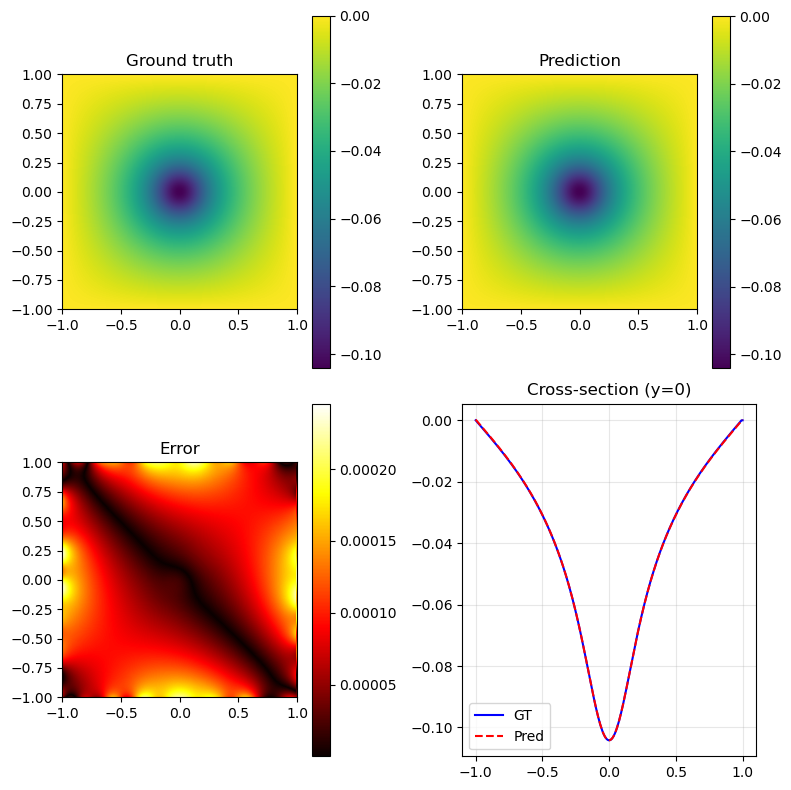

In [15]:
pred_phi_final = (torch.tanh(full_pred))[:, 0].numpy().reshape(256, 256)

# Error map (absolute)
error_absolute = np.abs(pred_phi_final - phi_gt)

fig, axes = plt.subplots(2, 2, figsize=(8, 8))

# Ground truth
im0 = axes[0, 0].imshow(phi_gt, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
axes[0, 0].set_title("Ground truth")
plt.colorbar(im0, ax=axes[0, 0])

# Prediction
im1 = axes[0, 1].imshow(pred_phi_final, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
axes[0, 1].set_title("Prediction")
plt.colorbar(im1, ax=axes[0, 1])

# Absolute error
im2 = axes[1, 0].imshow(error_absolute, cmap="hot", extent=[-1, 1, -1, 1], origin="lower")
axes[1, 0].set_title("Error")
plt.colorbar(im2, ax=axes[1, 0])

# Cross-section at y = 0
y_center_idx = 128
axes[1, 1].plot(x_gt, phi_gt[:, y_center_idx], "b-", label="GT")
axes[1, 1].plot(x_gt, pred_phi_final[:, y_center_idx], "r--", label="Pred")
axes[1, 1].set_title("Cross-section (y=0)")
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
plt.tight_layout()
plt.show()

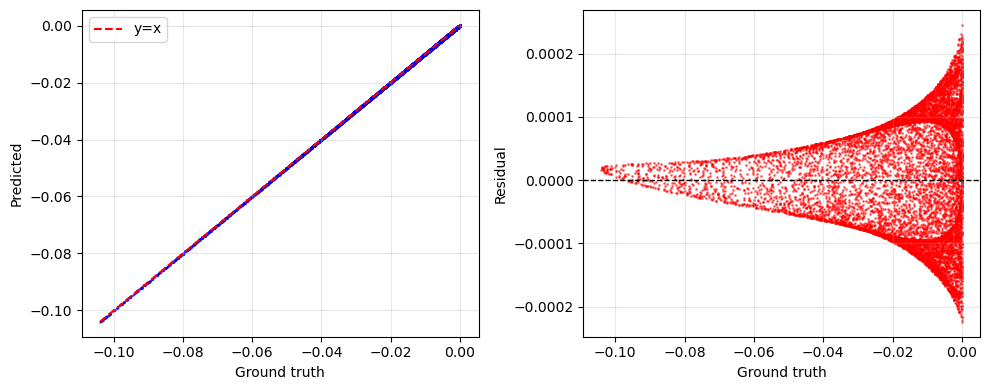

In [16]:
# Flatten predictions and ground truth
pred_flat = pred_phi_final.flatten()
gt_flat = phi_gt.flatten()

# Optional subsampling for speed
if len(pred_flat) > 10_000:
    idx = np.random.choice(len(pred_flat), 10_000, replace=False)
    pred_sample = pred_flat[idx]
    gt_sample = gt_flat[idx]
else:
    pred_sample = pred_flat
    gt_sample = gt_flat

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Predicted vs ground truth
axes[0].scatter(gt_sample, pred_sample, s=1, alpha=0.5, c="blue")
min_val = min(gt_sample.min(), pred_sample.min())
max_val = max(gt_sample.max(), pred_sample.max())
axes[0].plot([min_val, max_val], [min_val, max_val], "r--", linewidth=1.5, label="y=x")
axes[0].set_xlabel("Ground truth")
axes[0].set_ylabel("Predicted")
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Residuals vs ground truth
residuals = pred_sample - gt_sample
axes[1].scatter(gt_sample, residuals, s=1, alpha=0.5, c="red")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].set_xlabel("Ground truth")
axes[1].set_ylabel("Residual")
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

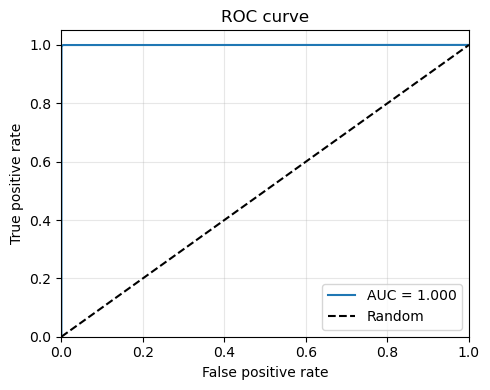

ROC AUC: 0.999989


In [17]:
# Compute ROC curve and AUC
gt_flat = phi_gt.flatten()
pred_flat = pred_phi_final.flatten()
threshold = np.median(gt_flat)
y_true = (gt_flat > threshold).astype(int)
y_score = pred_flat

fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--", label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
print(f"ROC AUC: {roc_auc:.6f}")

---

## ReLU and Tanh Comparisons


In [18]:
# ReLU-based MLP for comparison with SIREN
class ReLULayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False):
        super().__init__()
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                nn.init.xavier_uniform_(self.linear.weight, gain=0.1)
            else:
                nn.init.xavier_uniform_(self.linear.weight, gain=1.0)
            if self.linear.bias is not None:
                nn.init.zeros_(self.linear.bias)

    def forward(self, input):
        return self.relu(self.linear(input))

    def forward_with_intermediate(self, input):
        intermediate = self.linear(input)
        return self.relu(intermediate), intermediate

class ReLU_MLP(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False):
        super().__init__()

        self.net = []
        self.net.append(ReLULayer(in_features, hidden_features, is_first=True))

        for i in range(hidden_layers):
            self.net.append(ReLULayer(hidden_features, hidden_features, is_first=False))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            nn.init.xavier_uniform_(final_linear.weight, gain=0.01)
            if final_linear.bias is not None:
                nn.init.zeros_(final_linear.bias)
            self.net.append(final_linear)
        else:
            self.net.append(ReLULayer(hidden_features, out_features, is_first=False))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, ReLULayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


In [ ]:
# Tanh-based MLP for comparison with SIREN
class TanhLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True, is_first=False):
        super().__init__()
        self.is_first = is_first
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        self.tanh = nn.Tanh()
        self.init_weights()

    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                nn.init.xavier_uniform_(self.linear.weight, gain=0.1)
            else:
                nn.init.xavier_uniform_(self.linear.weight, gain=1.0)
            if self.linear.bias is not None:
                nn.init.zeros_(self.linear.bias)

    def forward(self, input):
        return self.tanh(self.linear(input))

    def forward_with_intermediate(self, input):
        intermediate = self.linear(input)
        return self.tanh(intermediate), intermediate

class Tanh_MLP(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False):
        super().__init__()

        self.net = []
        self.net.append(TanhLayer(in_features, hidden_features, is_first=True))

        for i in range(hidden_layers):
            self.net.append(TanhLayer(hidden_features, hidden_features, is_first=False))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            nn.init.xavier_uniform_(final_linear.weight, gain=0.01)
            if final_linear.bias is not None:
                nn.init.zeros_(final_linear.bias)
            self.net.append(final_linear)
        else:
            self.net.append(TanhLayer(hidden_features, out_features, is_first=False))

        self.net = nn.Sequential(*self.net)

    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True)
        output = self.net(coords)
        return output, coords

    def forward_with_activations(self, coords, retain_grad=False):
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, TanhLayer):
                x, intermed = layer.forward_with_intermediate(x)

                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()

                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else:
                x = layer(x)

                if retain_grad:
                    x.retain_grad()

            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations


In [20]:
# ReLU model for scalar potential φ
pb_relu = ReLU_MLP(in_features=2, out_features=1, hidden_features=256, hidden_layers=4, outermost_linear=True).to(device)

# Initialize final layer for small, slightly negative outputs
with torch.no_grad():
    final_layer = pb_relu.net[-1]
    if isinstance(final_layer, nn.Linear):
        nn.init.normal_(final_layer.weight, mean=0.0, std=0.01)
        if final_layer.bias is not None:
            nn.init.constant_(final_layer.bias, -0.05)


ReLU Step 0, Loss: 0.212927


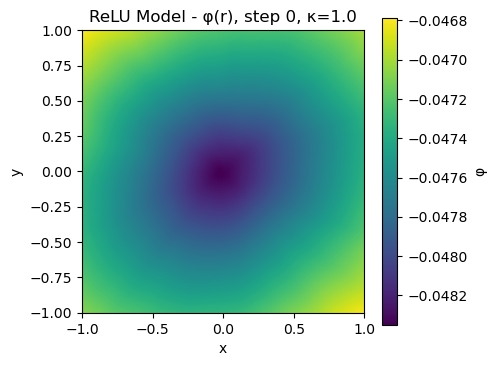

ReLU Step 99, Loss: 0.001453


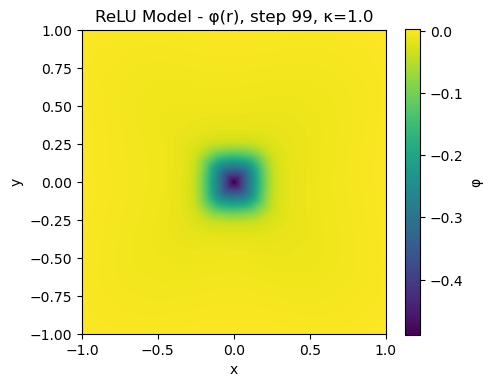

ReLU Step 199, Loss: 0.000355


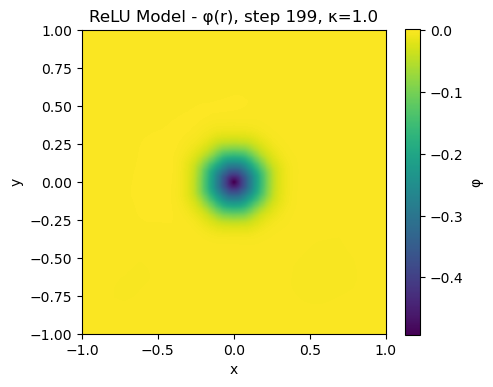

ReLU Step 299, Loss: 0.000309


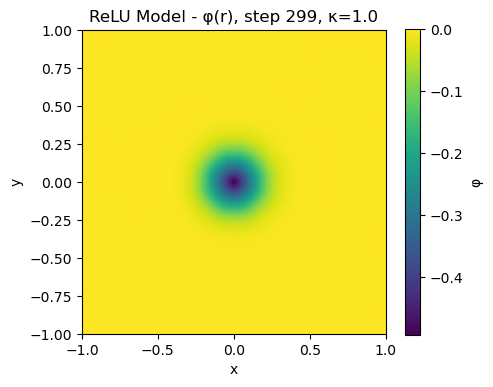

ReLU Step 399, Loss: 0.001666


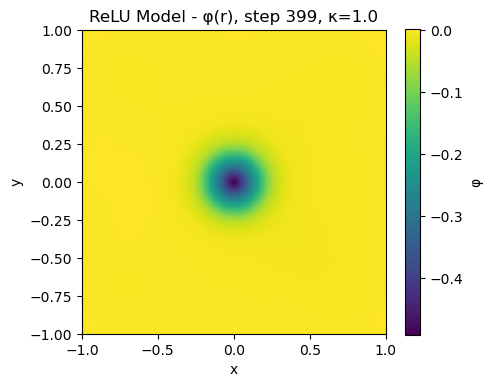

ReLU Step 499, Loss: 0.000369


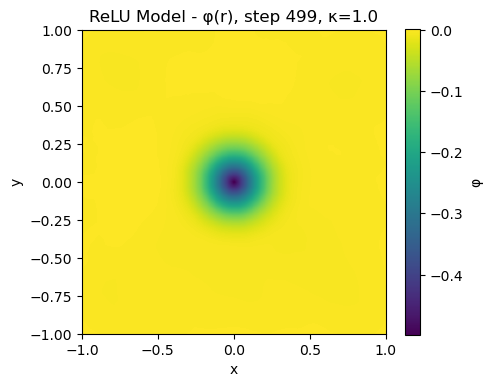

ReLU Step 599, Loss: 0.000800


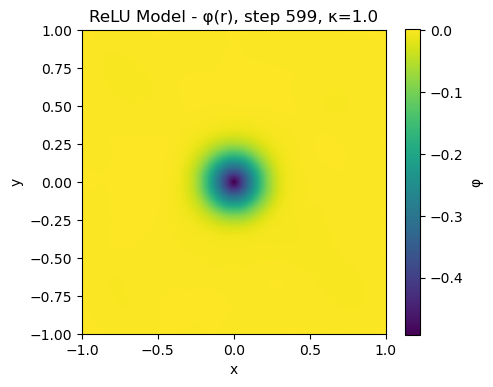

ReLU Step 699, Loss: 0.000434


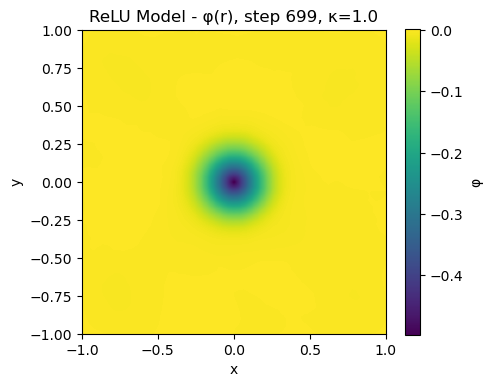

ReLU Step 799, Loss: 0.000405


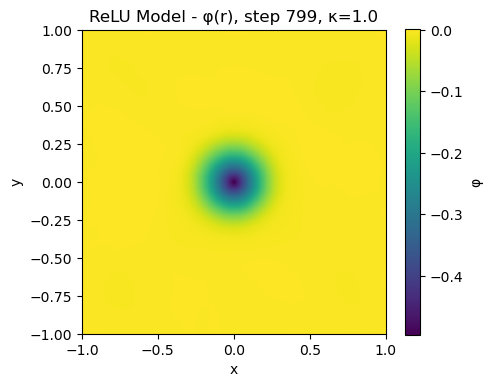

ReLU Step 899, Loss: 0.000338


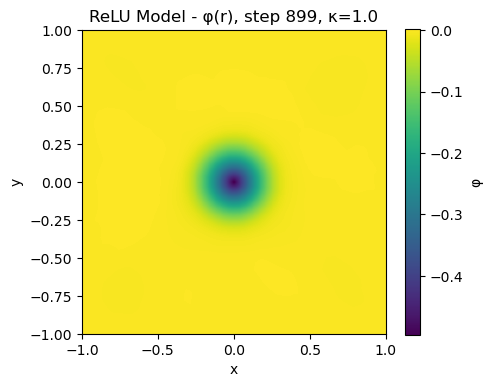

ReLU Step 999, Loss: 0.000293


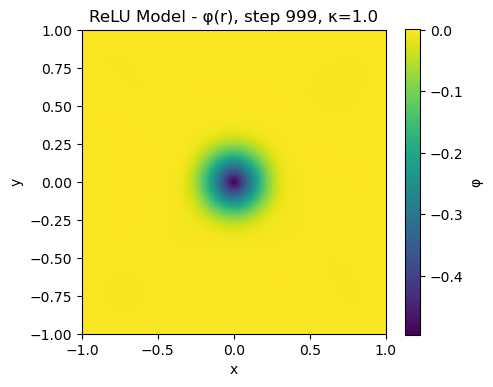

In [22]:
# Training setup for ReLU model
save_dir_pb_relu = "./checkpoints_pb_relu"
os.makedirs(save_dir_pb_relu, exist_ok=True)

dataloader_pb_relu = DataLoader(
    pb_obj,
    batch_size=16384,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

# Hyperparameters
total_steps_pb_relu = 1000
kappa = 1.0
initial_lr_pb_relu = 1e-4

optim_pb_relu = torch.optim.Adam(
    pb_relu.parameters(),
    lr=initial_lr_pb_relu,
    betas=(0.9, 0.999),
    weight_decay=1e-6,
)

# Cosine learning rate decay
def get_lr_pb_relu(step: int) -> float:
    t = step / max(total_steps_pb_relu - 1, 1)
    return 0.5 * initial_lr_pb_relu * (1.0 + np.cos(np.pi * t))

best_loss_pb_relu = float("inf")
best_step_relu = 0
best_checkpoint_path_relu = os.path.join(save_dir_pb_relu, "best_model.pth")

loss_history_pb_relu = []
pde_loss_history_relu = []
boundary_loss_history_relu = []
grad_norm_history_relu = []

for step in range(total_steps_pb_relu):
    start_time = time.time()

    # Update learning rate
    current_lr = get_lr_pb_relu(step)
    for param_group in optim_pb_relu.param_groups:
        param_group["lr"] = current_lr

    pb_relu.train()
    total_loss = 0.0
    total_pde_loss = 0.0
    total_boundary_loss = 0.0
    total_grad_norm = 0.0
    total_samples = 0
    num_batches = 0

    for coords, gt_vals in dataloader_pb_relu:
        coords = coords.to(device)
        gt_vals = gt_vals.to(device)

        pred, coords_grad = pb_relu(coords)
        loss, pde_loss, boundary_loss = poisson_boltzmann_mse(pred, coords_grad, kappa, 10.0)

        optim_pb_relu.zero_grad(set_to_none=True)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(pb_relu.parameters(), max_norm=1.0)
        optim_pb_relu.step()

        batch_size = coords.shape[0]
        total_loss += loss.item() * batch_size
        total_pde_loss += pde_loss.item() * batch_size
        total_boundary_loss += boundary_loss.item() * batch_size
        total_grad_norm += grad_norm
        total_samples += batch_size
        num_batches += 1

    if total_samples == 0:
        continue

    avg_loss = total_loss / total_samples
    avg_pde_loss = total_pde_loss / total_samples
    avg_boundary_loss = total_boundary_loss / total_samples
    avg_grad_norm = total_grad_norm / num_batches if num_batches > 0 else 0.0

    loss_history_pb_relu.append(avg_loss)
    pde_loss_history_relu.append(avg_pde_loss)
    boundary_loss_history_relu.append(avg_boundary_loss)
    grad_norm_history_relu.append(avg_grad_norm)

    # Save best model
    if avg_loss < best_loss_pb_relu:
        best_loss_pb_relu = avg_loss
        best_step_relu = step
        torch.save(
            {
                "step": step,
                "model_state_dict": pb_relu.state_dict(),
                "optimizer_state_dict": optim_pb_relu.state_dict(),
                "loss": avg_loss,
                "pde_loss": avg_pde_loss,
                "boundary_loss": avg_boundary_loss,
                "kappa": kappa,
            },
            best_checkpoint_path_relu,
        )

    # Log and visualize periodically
    if step == 0 or (step + 1) % 100 == 0:
        print(f"ReLU Step {step}, Loss: {avg_loss:.6f}")

        pb_relu.eval()
        with torch.no_grad():
            # Generate predictions for visualization
            full_coords = pb_obj.coords
            batch_size_vis = 16384
            preds = []
            for i in range(0, len(full_coords), batch_size_vis):
                batch = full_coords[i : i + batch_size_vis].to(device)
                pred_batch, _ = pb_relu(batch)
                preds.append(pred_batch.cpu())
            full_pred_relu = torch.cat(preds, dim=0)
            pred_phi_relu = torch.tanh(full_pred_relu)[:, 0].numpy().reshape(256, 256)

        plt.figure(figsize=(5, 4))
        plt.imshow(pred_phi_relu, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
        plt.title(f"ReLU Model - φ(r), step {step}, κ={kappa}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.colorbar(label="φ")
        plt.tight_layout()
        plt.show()


### Instantiate Tanh Model for Poisson-Boltzmann


In [23]:
# Tanh model for scalar potential φ
pb_tanh = Tanh_MLP(
    in_features=2,
    out_features=1,
    hidden_features=256,
    hidden_layers=4,
    outermost_linear=True,
).to(device)

# Initialize final layer for small, slightly negative outputs
with torch.no_grad():
    final_layer = pb_tanh.net[-1]
    if isinstance(final_layer, nn.Linear):
        nn.init.normal_(final_layer.weight, mean=0.0, std=0.01)
        if final_layer.bias is not None:
            nn.init.constant_(final_layer.bias, -0.05)


### Train Tanh Model


Tanh Step 0, Loss: 0.212842


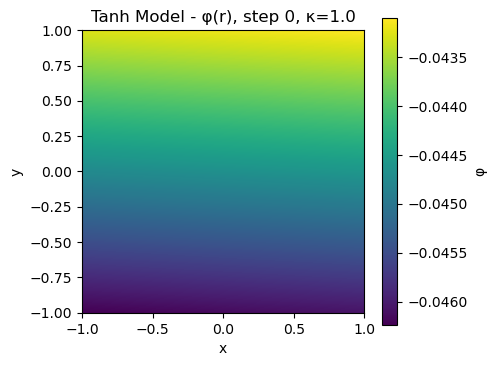

Tanh Step 99, Loss: 0.194270


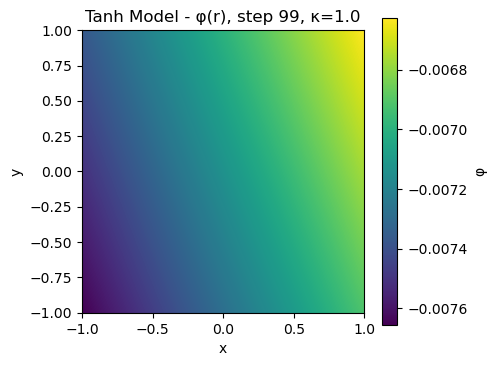

Tanh Step 199, Loss: 0.194269


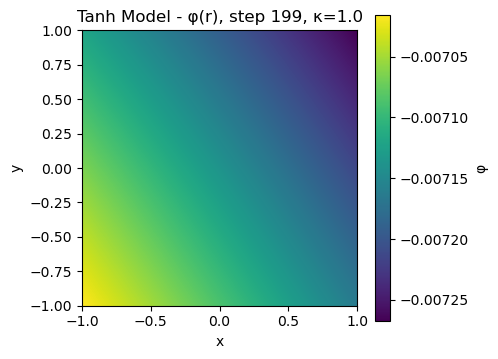

Tanh Step 299, Loss: 0.194269


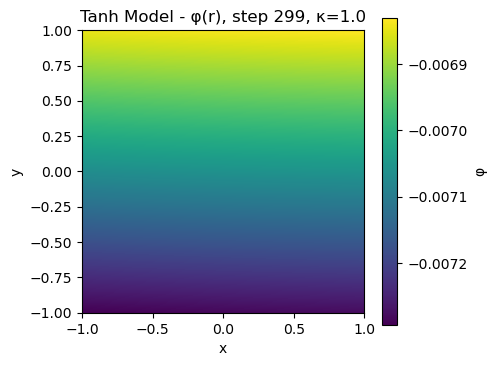

Tanh Step 399, Loss: 0.194269


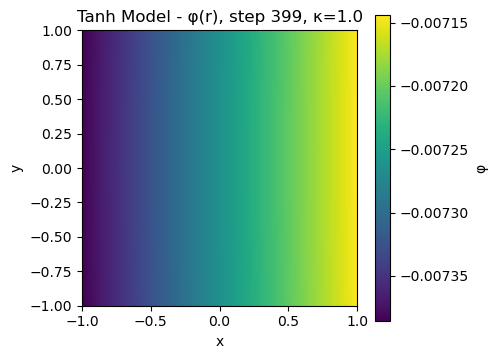

Tanh Step 499, Loss: 0.194268


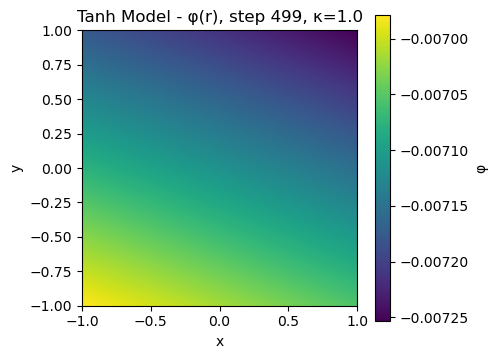

Tanh Step 599, Loss: 0.194268


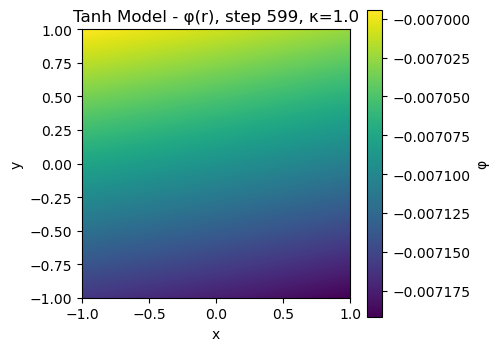

Tanh Step 699, Loss: 0.194268


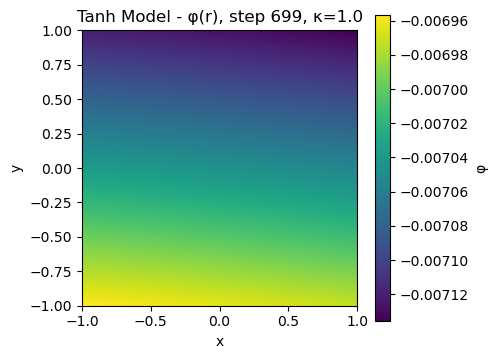

Tanh Step 799, Loss: 0.194267


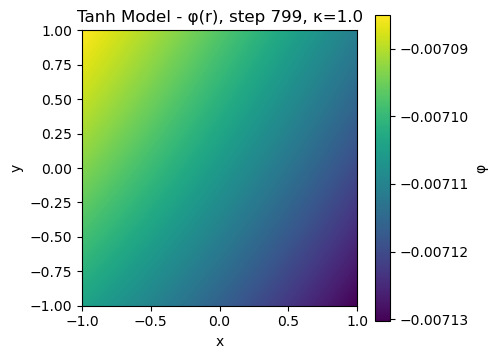

Tanh Step 899, Loss: 0.194267


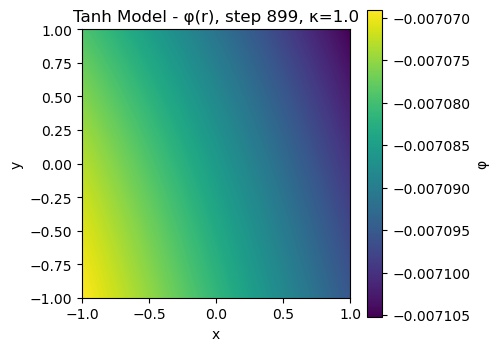

Tanh Step 999, Loss: 0.194267


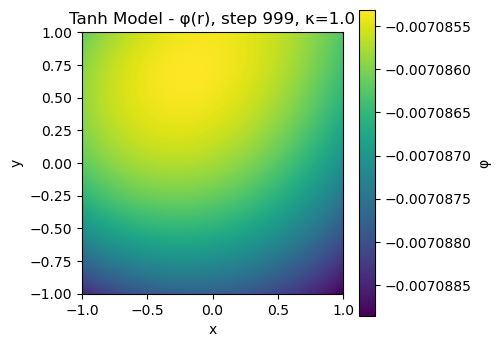

In [24]:
# Training setup for Tanh model
save_dir_pb_tanh = "./checkpoints_pb_tanh"
os.makedirs(save_dir_pb_tanh, exist_ok=True)

dataloader_pb_tanh = DataLoader(
    pb_obj,
    batch_size=16384,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

# Hyperparameters
total_steps_pb_tanh = 1000
kappa = 1.0
initial_lr_pb_tanh = 1e-4

optim_pb_tanh = torch.optim.Adam(
    pb_tanh.parameters(),
    lr=initial_lr_pb_tanh,
    betas=(0.9, 0.999),
    weight_decay=1e-6,
)

# Cosine learning rate decay
def get_lr_pb_tanh(step: int) -> float:
    t = step / max(total_steps_pb_tanh - 1, 1)
    return 0.5 * initial_lr_pb_tanh * (1.0 + np.cos(np.pi * t))

best_loss_pb_tanh = float("inf")
best_step_tanh = 0
best_checkpoint_path_tanh = os.path.join(save_dir_pb_tanh, "best_model.pth")

loss_history_pb_tanh = []
pde_loss_history_tanh = []
boundary_loss_history_tanh = []
grad_norm_history_tanh = []

for step in range(total_steps_pb_tanh):
    start_time = time.time()

    # Update learning rate
    current_lr = get_lr_pb_tanh(step)
    for param_group in optim_pb_tanh.param_groups:
        param_group["lr"] = current_lr

    pb_tanh.train()
    total_loss = 0.0
    total_pde_loss = 0.0
    total_boundary_loss = 0.0
    total_grad_norm = 0.0
    total_samples = 0
    num_batches = 0

    for coords, gt_vals in dataloader_pb_tanh:
        coords = coords.to(device)
        gt_vals = gt_vals.to(device)

        pred, coords_grad = pb_tanh(coords)
        loss, pde_loss, boundary_loss = poisson_boltzmann_mse(pred, coords_grad, kappa, 10.0)

        optim_pb_tanh.zero_grad(set_to_none=True)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(pb_tanh.parameters(), max_norm=1.0)
        optim_pb_tanh.step()

        batch_size = coords.shape[0]
        total_loss += loss.item() * batch_size
        total_pde_loss += pde_loss.item() * batch_size
        total_boundary_loss += boundary_loss.item() * batch_size
        total_grad_norm += grad_norm
        total_samples += batch_size
        num_batches += 1

    if total_samples == 0:
        continue

    avg_loss = total_loss / total_samples
    avg_pde_loss = total_pde_loss / total_samples
    avg_boundary_loss = total_boundary_loss / total_samples
    avg_grad_norm = total_grad_norm / num_batches if num_batches > 0 else 0.0

    loss_history_pb_tanh.append(avg_loss)
    pde_loss_history_tanh.append(avg_pde_loss)
    boundary_loss_history_tanh.append(avg_boundary_loss)
    grad_norm_history_tanh.append(avg_grad_norm)

    # Save best model
    if avg_loss < best_loss_pb_tanh:
        best_loss_pb_tanh = avg_loss
        best_step_tanh = step
        torch.save(
            {
                "step": step,
                "model_state_dict": pb_tanh.state_dict(),
                "optimizer_state_dict": optim_pb_tanh.state_dict(),
                "loss": avg_loss,
                "pde_loss": avg_pde_loss,
                "boundary_loss": avg_boundary_loss,
                "kappa": kappa,
            },
            best_checkpoint_path_tanh,
        )

    # Log and visualize periodically
    if step == 0 or (step + 1) % 100 == 0:
        print(f"Tanh Step {step}, Loss: {avg_loss:.6f}")

        pb_tanh.eval()
        with torch.no_grad():
            # Generate predictions for visualization
            full_coords = pb_obj.coords
            batch_size_vis = 16384
            preds = []
            for i in range(0, len(full_coords), batch_size_vis):
                batch = full_coords[i : i + batch_size_vis].to(device)
                pred_batch, _ = pb_tanh(batch)
                preds.append(pred_batch.cpu())
            full_pred_tanh = torch.cat(preds, dim=0)
            pred_phi_tanh = torch.tanh(full_pred_tanh)[:, 0].numpy().reshape(256, 256)

        plt.figure(figsize=(5, 4))
        plt.imshow(pred_phi_tanh, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
        plt.title(f"Tanh Model - φ(r), step {step}, κ={kappa}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.colorbar(label="φ")
        plt.tight_layout()
        plt.show()


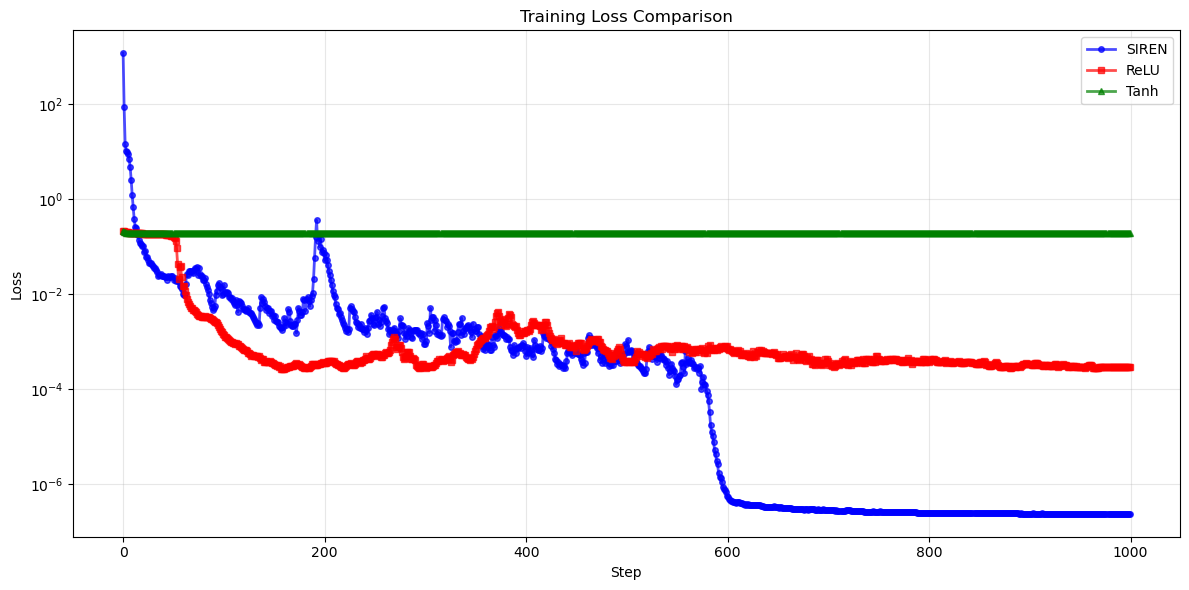

SIREN: 1.194632e+03 -> 2.366269e-07
ReLU:  2.129267e-01 -> 2.929678e-04
Tanh:  2.128423e-01 -> 1.942673e-01


In [25]:
if len(loss_history_pb) > 0 and len(loss_history_pb_relu) > 0 and len(loss_history_pb_tanh) > 0:
    plt.figure(figsize=(12, 6))
    plt.plot(loss_history_pb, 'b-o', linewidth=2, markersize=4, label='SIREN', alpha=0.7)
    plt.plot(loss_history_pb_relu, 'r-s', linewidth=2, markersize=4, label='ReLU', alpha=0.7)
    plt.plot(loss_history_pb_tanh, 'g-^', linewidth=2, markersize=4, label='Tanh', alpha=0.7)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.yscale('log')
    plt.tight_layout()
    plt.show()
    
    print(f"SIREN: {loss_history_pb[0]:.6e} -> {loss_history_pb[-1]:.6e}")
    print(f"ReLU:  {loss_history_pb_relu[0]:.6e} -> {loss_history_pb_relu[-1]:.6e}")
    print(f"Tanh:  {loss_history_pb_tanh[0]:.6e} -> {loss_history_pb_tanh[-1]:.6e}")


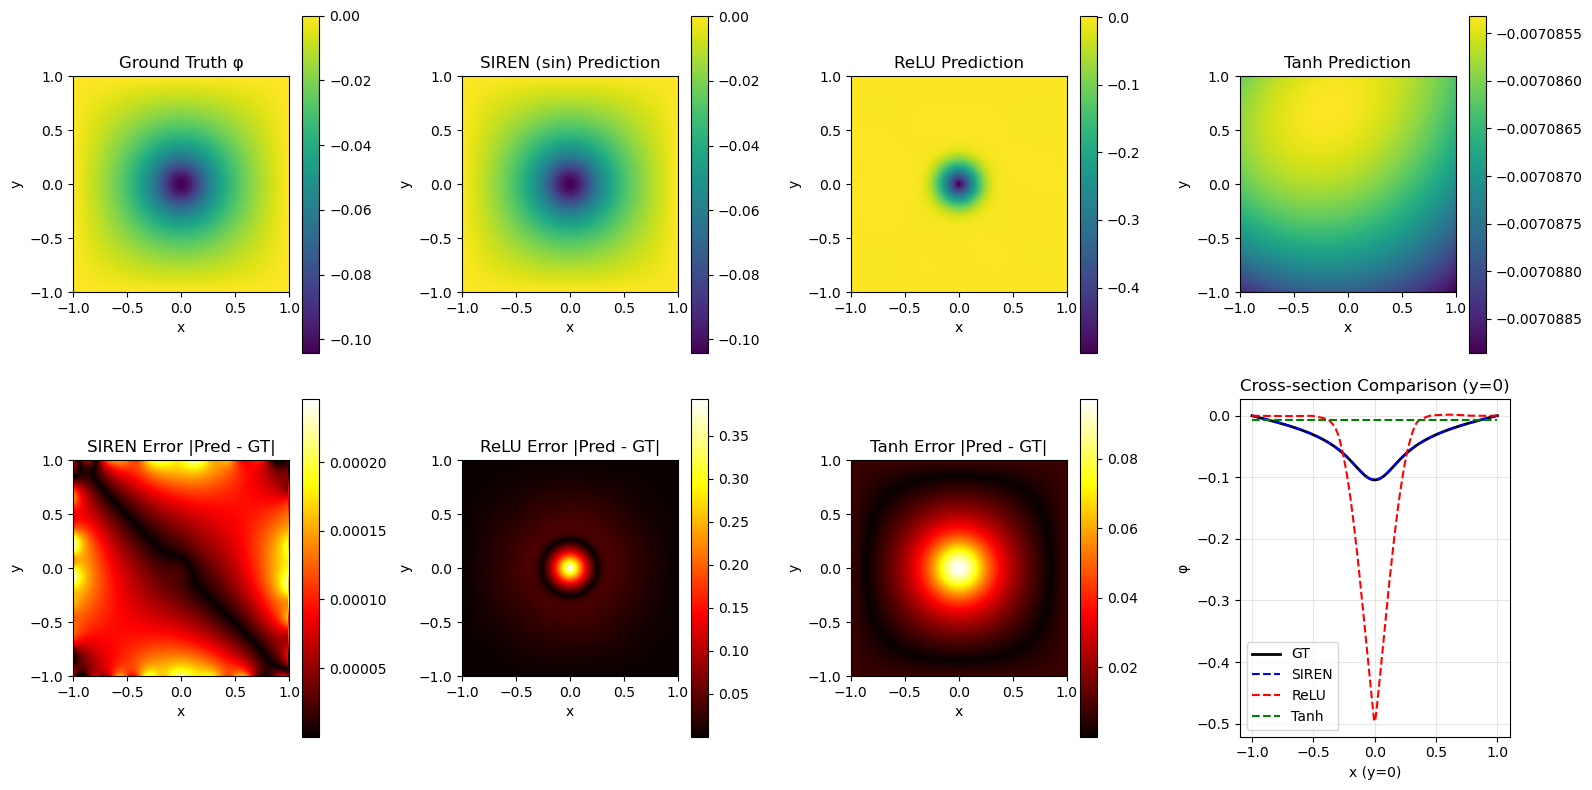

SIREN: MAE=7.960835e-05, Max Error=2.457090e-04
ReLU:  MAE=1.813861e-02, Max Error=3.923983e-01
Tanh:  MAE=1.439421e-02, Max Error=9.708165e-02


In [27]:
# Generate predictions from all three models for comparison
pb_siren.eval()
pb_relu.eval()
pb_tanh.eval()

with torch.no_grad():
    full_coords = pb_obj.coords
    batch_size_vis = 16384
    
    # SIREN predictions
    preds_siren = []
    for i in range(0, len(full_coords), batch_size_vis):
        batch = full_coords[i : i + batch_size_vis].to(device)
        pred_batch, _ = pb_siren(batch)
        preds_siren.append(pred_batch.cpu())
    full_pred_siren = torch.cat(preds_siren, dim=0)
    pred_phi_siren = torch.tanh(full_pred_siren)[:, 0].numpy().reshape(256, 256)
    
    # ReLU predictions
    preds_relu = []
    for i in range(0, len(full_coords), batch_size_vis):
        batch = full_coords[i : i + batch_size_vis].to(device)
        pred_batch, _ = pb_relu(batch)
        preds_relu.append(pred_batch.cpu())
    full_pred_relu = torch.cat(preds_relu, dim=0)
    pred_phi_relu = torch.tanh(full_pred_relu)[:, 0].numpy().reshape(256, 256)
    
    # Tanh predictions
    preds_tanh = []
    for i in range(0, len(full_coords), batch_size_vis):
        batch = full_coords[i : i + batch_size_vis].to(device)
        pred_batch, _ = pb_tanh(batch)
        preds_tanh.append(pred_batch.cpu())
    full_pred_tanh = torch.cat(preds_tanh, dim=0)
    pred_phi_tanh = torch.tanh(full_pred_tanh)[:, 0].numpy().reshape(256, 256)

# Visual comparison
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Ground truth
im0 = axes[0, 0].imshow(phi_gt, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
axes[0, 0].set_title("Ground Truth φ")
axes[0, 0].set_xlabel("x")
axes[0, 0].set_ylabel("y")
plt.colorbar(im0, ax=axes[0, 0])

# SIREN
im1 = axes[0, 1].imshow(pred_phi_siren, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
axes[0, 1].set_title("SIREN (sin) Prediction")
axes[0, 1].set_xlabel("x")
axes[0, 1].set_ylabel("y")
plt.colorbar(im1, ax=axes[0, 1])

# ReLU
im2 = axes[0, 2].imshow(pred_phi_relu, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
axes[0, 2].set_title("ReLU Prediction")
axes[0, 2].set_xlabel("x")
axes[0, 2].set_ylabel("y")
plt.colorbar(im2, ax=axes[0, 2])

# Tanh
im3 = axes[0, 3].imshow(pred_phi_tanh, cmap="viridis", extent=[-1, 1, -1, 1], origin="lower")
axes[0, 3].set_title("Tanh Prediction")
axes[0, 3].set_xlabel("x")
axes[0, 3].set_ylabel("y")
plt.colorbar(im3, ax=axes[0, 3])

# Error maps
error_siren = np.abs(pred_phi_siren - phi_gt)
error_relu = np.abs(pred_phi_relu - phi_gt)
error_tanh = np.abs(pred_phi_tanh - phi_gt)

im4 = axes[1, 0].imshow(error_siren, cmap="hot", extent=[-1, 1, -1, 1], origin="lower")
axes[1, 0].set_title("SIREN Error |Pred - GT|")
axes[1, 0].set_xlabel("x")
axes[1, 0].set_ylabel("y")
plt.colorbar(im4, ax=axes[1, 0])

im5 = axes[1, 1].imshow(error_relu, cmap="hot", extent=[-1, 1, -1, 1], origin="lower")
axes[1, 1].set_title("ReLU Error |Pred - GT|")
axes[1, 1].set_xlabel("x")
axes[1, 1].set_ylabel("y")
plt.colorbar(im5, ax=axes[1, 1])

im6 = axes[1, 2].imshow(error_tanh, cmap="hot", extent=[-1, 1, -1, 1], origin="lower")
axes[1, 2].set_title("Tanh Error |Pred - GT|")
axes[1, 2].set_xlabel("x")
axes[1, 2].set_ylabel("y")
plt.colorbar(im6, ax=axes[1, 2])

# Cross-section comparison
y_center_idx = 128
axes[1, 3].plot(x_gt, phi_gt[:, y_center_idx], "k-", linewidth=2, label="GT")
axes[1, 3].plot(x_gt, pred_phi_siren[:, y_center_idx], "b--", linewidth=1.5, label="SIREN")
axes[1, 3].plot(x_gt, pred_phi_relu[:, y_center_idx], "r--", linewidth=1.5, label="ReLU")
axes[1, 3].plot(x_gt, pred_phi_tanh[:, y_center_idx], "g--", linewidth=1.5, label="Tanh")
axes[1, 3].set_xlabel("x (y=0)")
axes[1, 3].set_ylabel("φ")
axes[1, 3].set_title("Cross-section Comparison (y=0)")
axes[1, 3].grid(True, alpha=0.3)
axes[1, 3].legend()

plt.tight_layout()
plt.show()

# Print quantitative comparison
print(f"SIREN: MAE={np.mean(error_siren):.6e}, Max Error={np.max(error_siren):.6e}")
print(f"ReLU:  MAE={np.mean(error_relu):.6e}, Max Error={np.max(error_relu):.6e}")
print(f"Tanh:  MAE={np.mean(error_tanh):.6e}, Max Error={np.max(error_tanh):.6e}")


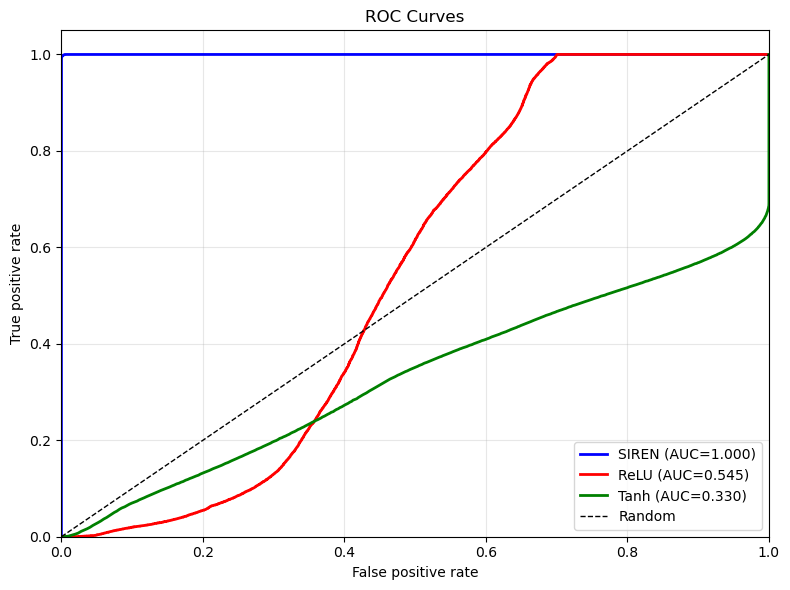

SIREN: 0.999989, ReLU: 0.545194, Tanh: 0.330400


In [28]:
# Compute ROC curves for all three models
gt_flat = phi_gt.flatten()
pred_flat_siren = pred_phi_siren.flatten()
pred_flat_relu = pred_phi_relu.flatten()
pred_flat_tanh = pred_phi_tanh.flatten()

threshold = np.median(gt_flat)
y_true = (gt_flat > threshold).astype(int)

# SIREN ROC
fpr_siren, tpr_siren, _ = roc_curve(y_true, pred_flat_siren)
roc_auc_siren = auc(fpr_siren, tpr_siren)

# ReLU ROC
fpr_relu, tpr_relu, _ = roc_curve(y_true, pred_flat_relu)
roc_auc_relu = auc(fpr_relu, tpr_relu)

# Tanh ROC
fpr_tanh, tpr_tanh, _ = roc_curve(y_true, pred_flat_tanh)
roc_auc_tanh = auc(fpr_tanh, tpr_tanh)

# Plot comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr_siren, tpr_siren, 'b-', linewidth=2, label=f'SIREN (AUC={roc_auc_siren:.3f})')
plt.plot(fpr_relu, tpr_relu, 'r-', linewidth=2, label=f'ReLU (AUC={roc_auc_relu:.3f})')
plt.plot(fpr_tanh, tpr_tanh, 'g-', linewidth=2, label=f'Tanh (AUC={roc_auc_tanh:.3f})')
plt.plot([0, 1], [0, 1], "k--", linewidth=1, label="Random")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC Curves")
plt.grid(True, alpha=0.3)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print(f"SIREN: {roc_auc_siren:.6f}, ReLU: {roc_auc_relu:.6f}, Tanh: {roc_auc_tanh:.6f}")


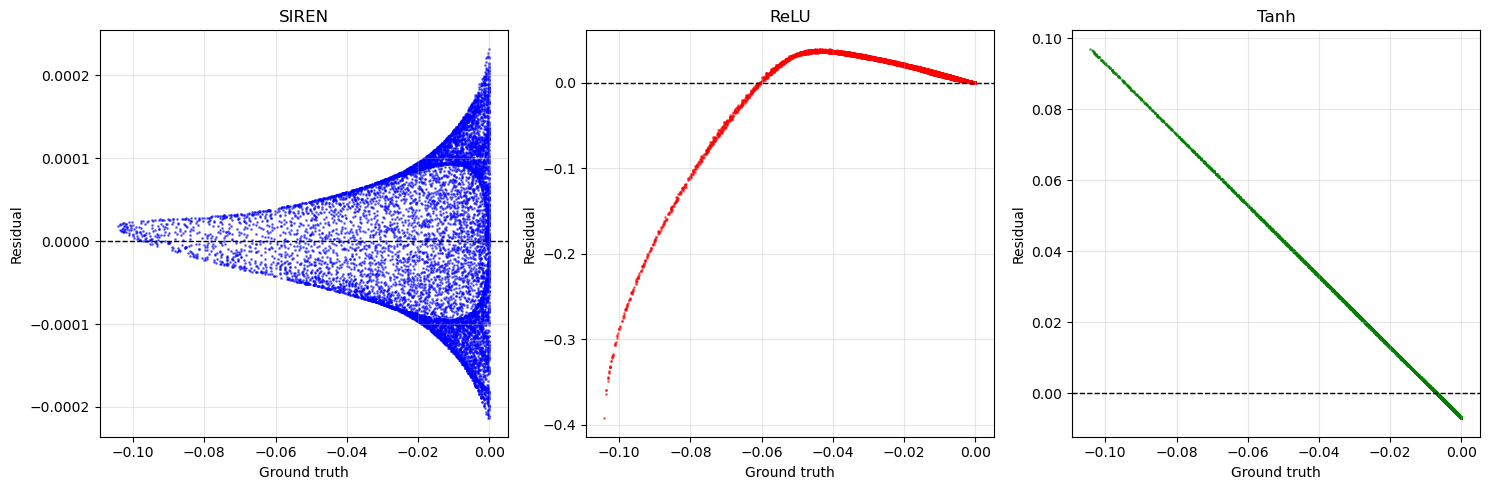

SIREN: mean=6.236066e-07, std=9.204462e-05
ReLU:  mean=6.363466e-03, std=3.767888e-02
Tanh:  mean=1.159047e-02, std=2.033319e-02


In [29]:
# Flatten predictions and ground truth for all three models
gt_flat = phi_gt.flatten()
pred_flat_siren = pred_phi_siren.flatten()
pred_flat_relu = pred_phi_relu.flatten()
pred_flat_tanh = pred_phi_tanh.flatten()

# Optional subsampling for speed
if len(pred_flat_siren) > 10_000:
    idx = np.random.choice(len(pred_flat_siren), 10_000, replace=False)
    gt_sample = gt_flat[idx]
    pred_sample_siren = pred_flat_siren[idx]
    pred_sample_relu = pred_flat_relu[idx]
    pred_sample_tanh = pred_flat_tanh[idx]
else:
    gt_sample = gt_flat
    pred_sample_siren = pred_flat_siren
    pred_sample_relu = pred_flat_relu
    pred_sample_tanh = pred_flat_tanh

# Compute residuals
residuals_siren = pred_sample_siren - gt_sample
residuals_relu = pred_sample_relu - gt_sample
residuals_tanh = pred_sample_tanh - gt_sample

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# SIREN: Residuals vs ground truth
axes[0].scatter(gt_sample, residuals_siren, s=1, alpha=0.5, c="blue")
axes[0].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[0].set_xlabel("Ground truth")
axes[0].set_ylabel("Residual")
axes[0].set_title("SIREN")
axes[0].grid(True, alpha=0.3)

# ReLU: Residuals vs ground truth
axes[1].scatter(gt_sample, residuals_relu, s=1, alpha=0.5, c="red")
axes[1].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[1].set_xlabel("Ground truth")
axes[1].set_ylabel("Residual")
axes[1].set_title("ReLU")
axes[1].grid(True, alpha=0.3)

# Tanh: Residuals vs ground truth
axes[2].scatter(gt_sample, residuals_tanh, s=1, alpha=0.5, c="green")
axes[2].axhline(y=0, color="black", linestyle="--", linewidth=1)
axes[2].set_xlabel("Ground truth")
axes[2].set_ylabel("Residual")
axes[2].set_title("Tanh")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"SIREN: mean={np.mean(residuals_siren):.6e}, std={np.std(residuals_siren):.6e}")
print(f"ReLU:  mean={np.mean(residuals_relu):.6e}, std={np.std(residuals_relu):.6e}")
print(f"Tanh:  mean={np.mean(residuals_tanh):.6e}, std={np.std(residuals_tanh):.6e}")
